In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [2]:
def get_sp500_tickers():
    table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    df = table[0]
    return df['Symbol'].tolist()

tickers = get_sp500_tickers()
start_date = '2014-01-01'
end_date = '2024-01-01'
prices = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2014-01-01 -> 2024-01-01)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [3]:
prices_clean = prices.dropna(axis=1)
returns = prices_clean.pct_change()[1:]
correlation = returns.corr()

def get_top_correlations(correlation_matrix, n):
    upper_tri = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    corr_flat = upper_tri.stack().reset_index()
    corr_flat.columns = ['Ticker1', 'Ticker2', 'Correlation']
    return corr_flat.sort_values(by='Correlation', ascending=False).head(n).reset_index(drop=True)

top_correlations = get_top_correlations(correlation, 100)
top_correlations.head(10)

,Ticker1,Ticker2,Correlation
0,GOOG,GOOGL,0.993626
1,NWS,NWSA,0.973984
2,FRT,REG,0.919657
3,EQR,UDR,0.914239
4,AVB,EQR,0.913791
5,MET,PRU,0.908795
6,FITB,RF,0.906665
7,CMS,XEL,0.904410
8,AVB,UDR,0.903432
9,FITB,KEY,0.900607


In [4]:
def coint_test(stock1, stock2):
    stock2 = sm.add_constant(stock2)
    model = sm.OLS(stock1, stock2).fit()
    return adfuller(model.resid)

def get_coint_results(pairs, prices, tolerance=0.05):
    ticks1, ticks2 = pairs['Ticker1'], pairs['Ticker2']
    adf_stats = []
    p_values = []
    for index, ticker1 in enumerate(ticks1):
        ticker2 = ticks2[index]
        coint_results = coint_test(prices[ticker1], prices[ticker2])
        adf_stats.append(coint_results[0])
        p_values.append(coint_results[1])
    df = pd.DataFrame({'Ticker1': ticks1, 'Ticker2': ticks2, 'ADF Statistic': adf_stats, 'p-value': p_values})
    df = df.sort_values(by='p-value')
    df = df[df['p-value'] < tolerance]
    return df.reset_index(drop=True)

coint_results = get_coint_results(top_correlations, prices_clean)
coint_results

,Ticker1,Ticker2,ADF Statistic,p-value
0,GOOG,GOOGL,-5.063661,0.000017
1,MA,V,-4.738193,0.000071
2,BAC,PNC,-4.288837,0.000464
3,FITB,PNC,-4.180838,0.000710
4,HBAN,PNC,-4.136581,0.000842
5,CMS,XEL,-4.047263,0.001182
6,KEY,ZION,-3.995573,0.001434
7,WEC,XEL,-3.947349,0.001713
8,GS,MS,-3.902417,0.002017
9,EQR,ESS,-3.757173,0.003377


Annualized Return: 0.05085108330124346
Annualized Standard Deviation: 0.03196150179623335
Sharpe Ratio: 1.5910104483024083


<Axes: xlabel='Date'>

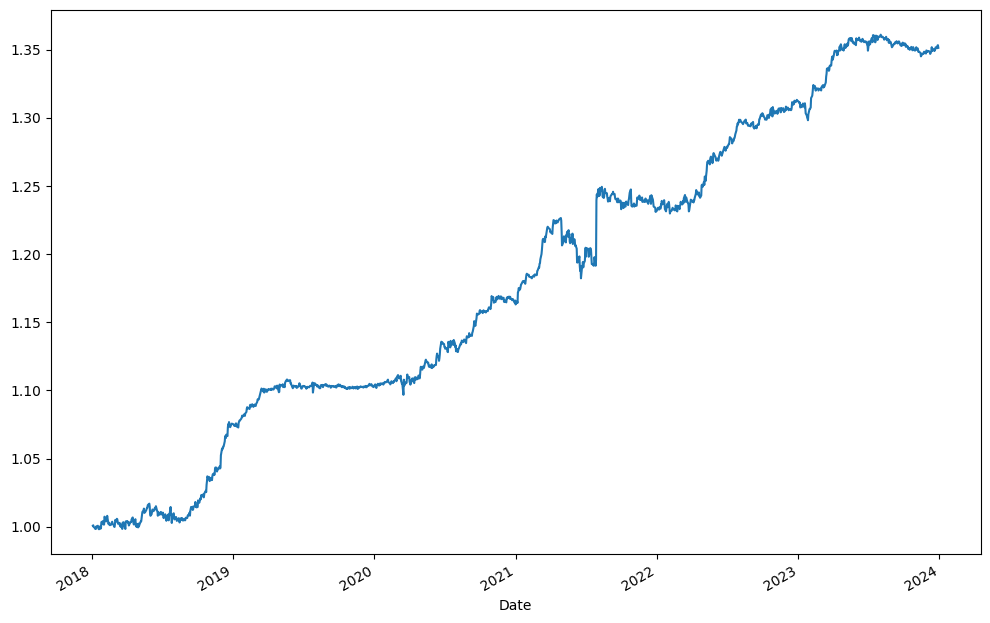

In [5]:
def pairs_backtest(prices1, prices2, lookback_days, buy_stds, sell_stds):
    # Calculate hedge ratios and spreads for lookback_days
    hedge_ratios = np.array([])
    spreads = np.array([])
    for i in range(lookback_days, 2*lookback_days):
        temp_prices1 = prices1.iloc[i-lookback_days:i]
        temp_prices2 = prices2.iloc[i-lookback_days:i]
        model = sm.OLS(temp_prices1, sm.add_constant(temp_prices2)).fit()
        hedge_ratios = np.append(hedge_ratios, model.params.iloc[1])
        spreads = np.append(spreads, model.resid.iloc[-1])

    # Calculate positions for remaining days
    positions1 = np.array([])
    positions2 = np.array([])
    for i in range(2*lookback_days, len(prices1)):
        temp_prices1 = prices1.iloc[i-lookback_days:i]
        temp_prices2 = prices2.iloc[i-lookback_days:i]
        model = sm.OLS(temp_prices1, sm.add_constant(temp_prices2)).fit()
        hedge_ratio = model.params.iloc[1]
        hedge_ratios = np.append(hedge_ratios, hedge_ratio)
        spread = model.resid.iloc[-1]
        spreads = np.append(spreads, spread)
        spread_mean = spreads[-lookback_days:].mean()
        spread_std = spreads[-lookback_days:].std()
        if spread > spread_mean + buy_stds*spread_std: # Spread is too high, short stock1 and long stock2
            positions1 = np.append(positions1, -1)
            positions2 = np.append(positions2, hedge_ratio)
        elif spread < spread_mean - sell_stds*spread_std: # Spread is too low, long stock1 and short stock2
            positions1 = np.append(positions1, 1)
            positions2 = np.append(positions2, -hedge_ratio)
        else: # Spread is normal, close positions
            positions1 = np.append(positions1, 0)
            positions2 = np.append(positions2, 0)

    # Calculate returns
    returns1 = prices1.pct_change().iloc[2*lookback_days:]
    returns2 = prices2.pct_change().iloc[2*lookback_days:]
    returns = returns1*positions1 + returns2*positions2
    cumulative_returns = (returns + 1).cumprod()

    # Prepare performance dataframe
    ticker1, ticker2 = prices1.name, prices2.name
    performance = {
        'Cumulative Returns': cumulative_returns,
        'Daily Returns': returns,
        ticker1+' Positions': positions1,
        ticker2+' Positions': positions2,
        'Spreads': spreads[lookback_days:],
        'Hedge Ratios': hedge_ratios[lookback_days:]
    }
    performance = pd.DataFrame(performance)
    return performance

google_strat = pairs_backtest(prices_clean['GOOG'], prices_clean['GOOGL'], 504, 0, 0)
google_returns = google_strat['Daily Returns'].mean()*252
google_std = google_strat['Daily Returns'].std()*np.sqrt(252)
print('Annualized Return:', google_returns)
print('Annualized Standard Deviation:', google_std)
print('Sharpe Ratio:', google_returns/google_std)
google_strat['Cumulative Returns'].plot(figsize=(12, 8))

In [6]:
def test_all_pairs(pairs, prices, lookback_days, buy_stds, sell_stds):
    results = {
        'Ticker1': [],
        'Ticker2': [],
        'Annualized Returns': [],
        'Annualized Standard Deviation': [],
        'Sharpe Ratio': []
    }
    for index, row in pairs.iterrows():
        ticker1, ticker2 = row['Ticker1'], row['Ticker2']
        strat = pairs_backtest(prices[ticker1], prices[ticker2], lookback_days, buy_stds, sell_stds)
        returns = strat['Daily Returns'].mean()*252
        std = strat['Daily Returns'].std()*np.sqrt(252)
        sharpe = returns/std
        results['Ticker1'].append(ticker1)
        results['Ticker2'].append(ticker2)
        results['Annualized Returns'].append(returns)
        results['Annualized Standard Deviation'].append(std)
        results['Sharpe Ratio'].append(sharpe)
    results = pd.DataFrame(results)
    results = results.sort_values(by='Sharpe Ratio', ascending=False).reset_index(drop=True)
    return results

all_pairs_results = test_all_pairs(coint_results, prices_clean, 504, 1, 1)
all_pairs_results.head(10)

,Ticker1,Ticker2,Annualized Returns,Annualized Standard Deviation,Sharpe Ratio
0,MCO,SPGI,0.132755,0.085467,1.553283
1,GOOG,GOOGL,0.032281,0.025054,1.288417
2,MA,V,0.219240,0.173937,1.260458
3,BAC,PNC,0.223543,0.193130,1.157473
4,DHI,LEN,0.127947,0.117441,1.089462
5,CMS,XEL,0.062317,0.070381,0.885419
6,WEC,XEL,0.101303,0.117176,0.864532
7,GS,MS,0.406286,0.471377,0.861914
8,CMS,LNT,0.063772,0.076028,0.838797
9,AEP,CMS,0.085672,0.141721,0.604515


Text(0.5, 1.0, 'Top 5 Pairs Trading Strategies')

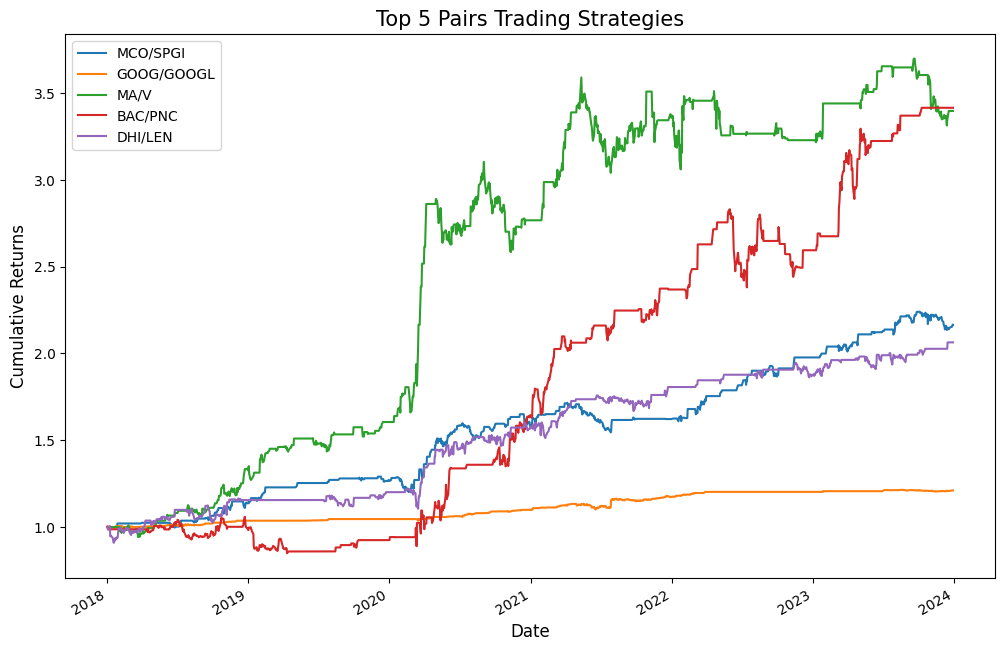

In [7]:
# Top 5 strategies
top_strats = pd.DataFrame()
for i in range(5):
    tick1, tick2 = all_pairs_results['Ticker1'][i], all_pairs_results['Ticker2'][i]
    strat = pairs_backtest(prices_clean[tick1], prices_clean[tick2], 504, 1, 1)
    top_strats[tick1+'/'+tick2] = strat['Daily Returns']

# Plot cumulative returns
(top_strats+1).cumprod().plot(figsize=(12, 8))
plt.ylabel('Cumulative Returns', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Top 5 Pairs Trading Strategies', fontsize=15)

Portfolio Annualized Return: 0.1946375491655722
Portfolio Annualized Standard Deviation: 0.08381138493284948
Portfolio Sharpe Ratio: 2.3223282770177076
[*********************100%%**********************]  1 of 1 completed


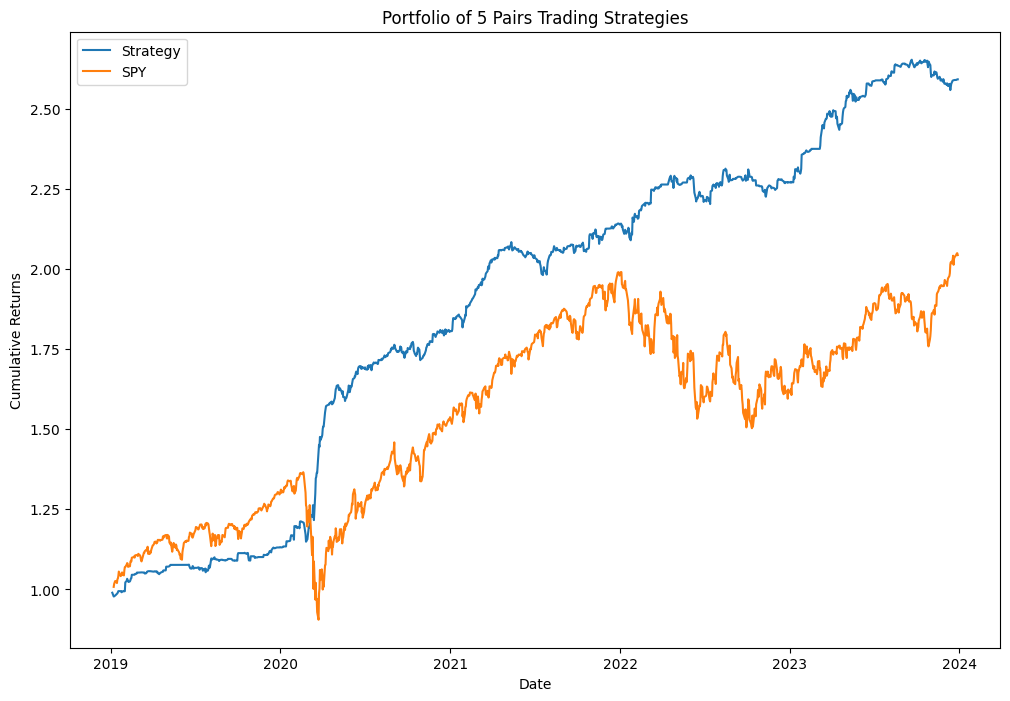

In [8]:
# Portfolio optimization of top 5 strategies
def portfolio_var(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def target_return_constraint(weights, mean_returns, target_return):
    return target_return - np.dot(weights, mean_returns*252)

def optimize_portfolio(daily_returns, target_return):
    mean_returns = daily_returns.mean()
    cov_matrix = daily_returns.cov()

    num_assets = len(mean_returns)

    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: target_return_constraint(x, mean_returns, target_return)}]
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = [1./num_assets]*num_assets

    opt_results = opt.minimize(portfolio_var, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

    return opt_results.x

target_returns = 0.2
portfolio_returns = np.array([])
for i in range(252, len(top_strats)):
    daily_returns = top_strats.iloc[:i]
    weights = optimize_portfolio(daily_returns, target_returns)
    portfolio_returns = np.append(portfolio_returns, np.dot(weights, top_strats.iloc[i]))
portfolio_returns = pd.Series(portfolio_returns, index=top_strats.iloc[252:].index)

# Strategy performance
port_mean = portfolio_returns.mean()*252
port_std = portfolio_returns.std()*np.sqrt(252)
print('Portfolio Annualized Return:', port_mean)
print('Portfolio Annualized Standard Deviation:', port_std)
print('Portfolio Sharpe Ratio:', port_mean/port_std)

# Plot performance
first_day = portfolio_returns.index[0]
spy = yf.download('SPY', start=first_day, end=end_date)['Adj Close'].pct_change()[1:]
plt.figure(figsize=(12, 8))
plt.plot((portfolio_returns+1).cumprod(), label='Strategy')
plt.plot((spy+1).cumprod(), label='SPY')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.title('Portfolio of 5 Pairs Trading Strategies')
plt.legend()